# Introduction

Training NN for image recognition of digits. 

# Import and init

In [ ]:
import os


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, 
                                     Dropout,
                                     Activation
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (cross_val_score,
                                     cross_val_predict,
                                     train_test_split
)


In [ ]:
# Setting random seeds to get reproducible results
np.random.seed(0)
tf.random.set_seed(1)

In [ ]:
def get_extreme_values(x_array: np.array) -> None:
    print(f"Values range:")
    print(f" - min: {x_array.reshape(-1).min()}")
    print(f" - max: {x_array.reshape(-1).max()}")



# Load data

As an alternative, we can load the MNIST dataset from the following source:

```py
import mnist

x_train, y_train = mnist.train_images(), mnist.train_labels()
x_test, y_test = mnist.test_images(), mnist.test_labels()
```

MNIST can also be fetched from sklearn.datasets:
```py
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

# This dataset is already shuffled into train set (first 60k images) and test set (last 60k images)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
```

Subsequently, it would have had to be processed in the way identical to the one described in this notebook (i.e., reshape, normalize by dividing by 256)

In [65]:
# Get the data
# TRAIN-TEST split
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(f"Size of the training set: {len(x_train):,}")
print(f"Size of the testing set: {len(x_test):,}")

Size of the training set: 60,000
Size of the testing set: 10,000


In [27]:
x_train.reshape(-1).max()

255

In [28]:
"""
Our features are matrices representing 28*28 images,
with each pixel representing black-and-white pixel with intensity 0-255. 
Let's check one image:
"""
print(f"Training matrix shape: {x_train.shape}")
get_extreme_values(x_train)


Training matrix shape: (60000, 28, 28)
Values range:
 - min: 0
 - max: 255


In [29]:
"""
Now let's check how images are represented
"""
print(f"Labels shape: {y_train.shape}")
print(f"Labels slice: {y_train[:5]}")


Labels shape: (60000,)
Labels slice: [5 0 4 1 9]


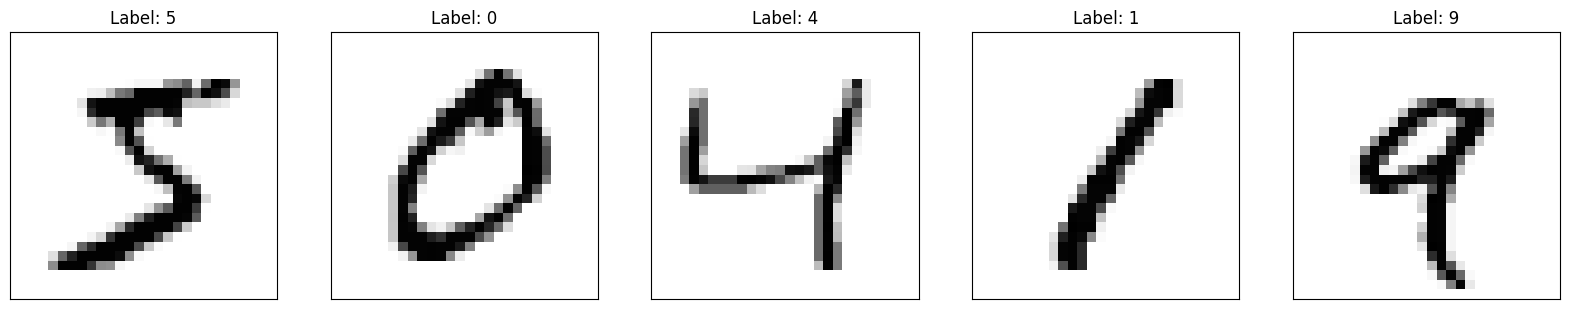

In [30]:
# Show examples with labels

fig = plt.figure(figsize=(20,20))
number = 5
for i in range(number):
	ax = fig.add_subplot(1, number, i+1, xticks=[], yticks=[])
	ax.imshow(x_train[i], cmap='Greys')
	ax.set_title(
    	f'Label: {str(y_train[i])}', 
     	# color='white'
    )


(84, 280)


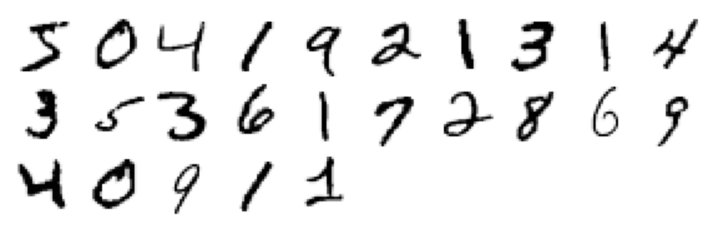

In [31]:
# Show more examples

def plot_digits(instances, images_per_row=10):
    plt.figure(figsize=(9,9))
    size=28
    images_per_row = min( len(instances), images_per_row )
    n_rows = (len(instances)-1) // images_per_row +1
    # Append empty images to fill the end of the grid, if needed
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size, size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    print(big_image.shape)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = 'Greys')
    plt.axis("off")

example_images = x_train[:25]
plot_digits(example_images, images_per_row=10)


# Pre-processing

In [32]:
"""
For a FNN, we need to reshape each image from (28*28) shape
to 28*28 = 784 array
"""

x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)
print(x_train.shape)

### Normalise for the values to be between 0 and 1
x_train_min, x_train_max = x_train.reshape(-1).min(), x_train.reshape(-1).max()
x_train = x_train / x_train_max
x_test = x_test / x_train_max
get_extreme_values(x_train)


(60000, 784)
Values range:
 - min: 0.0
 - max: 1.0


In [33]:
print(f"Number of features per image / data point: {x_train[0].shape}")


Number of features per image / data point: (784,)


In [34]:
print(x_train.shape, y_train.shape)

(60000, 784) (60000,)


In [35]:
x_train_smaller, x_val, y_train_smaller, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size = 0.08
)
print(x_train_smaller.shape, y_train_smaller.shape)
print(x_val.shape, y_val.shape)

(55200, 784) (55200,)
(4800, 784) (4800,)


In [60]:
"""
let's also generate the second variant of the train and test sets, 
in the form of one-hot encoded array,
so we can use it with Tensorflow with some activation functions
"""

for i in range(3):
	print(f"Before: {y_train_smaller[i]} | shape: {y_train_smaller[i].shape}")


y_train_smaller_2 = to_categorical(y_train_smaller, 10)
y_val_2 = to_categorical(y_val, 10)
y_test_2 = to_categorical(y_test, 10)


for i in range(3):
	print(f"After: {y_train_smaller_2[i]} | shape: {y_train_smaller_2[i].shape}")

Before: 6 | shape: ()
Before: 2 | shape: ()
Before: 7 | shape: ()
After: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] | shape: (10,)
After: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] | shape: (10,)
After: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] | shape: (10,)


# Train models

The Sklearn NN will have the following properties:
- 28px * 28px = 784 neurons (input layer)

## Linear SVM

In [38]:
from sklearn.linear_model import SGDClassifier


linear_svm_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
linear_svm_clf.fit(x_train_smaller, y_train_smaller)


SGDClassifier(random_state=42)

In [39]:
linear_svm_clf.predict([x_test[0]])

array([7], dtype=uint8)

In [40]:
print(linear_svm_clf.classes_)
# In this case, classes and indices coincide

for i in range(5):
    print("----")
    print(f" Real: {y_test[i]}")
    prediction = linear_svm_clf.predict([x_test[i]])
    print(f" Predicted: {prediction}")
    some_digit_scores = linear_svm_clf.decision_function([x_test[i]])
    print(some_digit_scores)


[0 1 2 3 4 5 6 7 8 9]
----
 Real: 7
 Predicted: [7]
[[ -6.33427471 -16.6149607   -5.21290342  -2.45400451  -9.02490781
   -5.70599282 -11.81959955   3.79005636  -6.40075278  -5.57010262]]
----
 Real: 2
 Predicted: [2]
[[ -3.78722273 -10.52527852   2.57974129  -3.2613558  -20.31900798
   -2.55875203  -3.1446392  -22.62202598  -6.72359567 -16.31396547]]
----
 Real: 1
 Predicted: [1]
[[-11.21587975   2.71881108  -2.3733045   -2.99986106  -4.47083054
   -2.59924637  -3.09178596  -2.65806462  -4.53883537  -4.39868153]]
----
 Real: 0
 Predicted: [0]
[[  4.96698054 -14.50567354  -4.57843276  -7.15931127 -12.2781102
   -5.37256348  -2.37851784  -6.2590195   -6.10902748  -8.09129679]]
----
 Real: 4
 Predicted: [4]
[[-4.37061321 -9.68019293 -3.45179391 -9.4711678   1.85629295 -6.81584053
  -4.23336712 -3.1126447  -4.46817733 -2.18732117]]


In [43]:
cross_val_score( linear_svm_clf, x_val, y_val, cv=3, scoring="f1_weighted" )

array([0.86843568, 0.8677447 , 0.8422922 ])

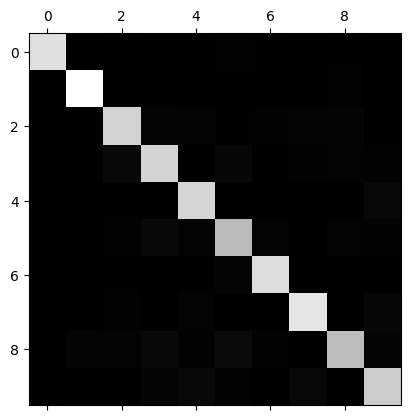

In [44]:
### This confusion matrix can be used for other algorithms, too

y_train_pred = cross_val_predict(linear_svm_clf, x_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

# The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or 
# that the classifier does not perform as well on 5s as on other digits
plt.matshow( conf_mx, cmap=plt.cm.gray )

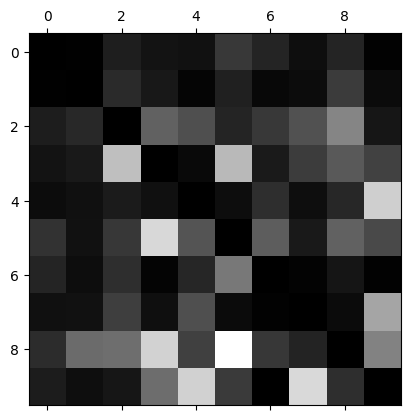

In [45]:
# coonfusion matrix, but only show errors (white - higher density of errors)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(x_train_smaller, y_train_smaller)


RandomForestClassifier(random_state=42)

In [48]:
forest_clf

print(forest_clf.classes_)
# In this case, classes and indices coincide

for i in range(5):
    print("----")
    print(f" Real: {y_test[i]}")
    prediction = forest_clf.predict([x_test[i]])
    print(f" Predicted: {prediction}")
    some_digit_scores = forest_clf.predict_proba([x_test[i]])
    print(some_digit_scores)

[0 1 2 3 4 5 6 7 8 9]
----
 Real: 7
 Predicted: [7]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
----
 Real: 2
 Predicted: [2]
[[0.02 0.02 0.86 0.03 0.01 0.   0.05 0.   0.01 0.  ]]
----
 Real: 1
 Predicted: [1]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
----
 Real: 0
 Predicted: [0]
[[0.94 0.   0.03 0.   0.   0.01 0.   0.01 0.   0.01]]
----
 Real: 4
 Predicted: [4]
[[0.   0.   0.01 0.01 0.92 0.   0.   0.02 0.01 0.03]]


In [49]:
cross_val_score( forest_clf, x_val, y_val, cv=3, scoring="f1_weighted" )

array([0.92460413, 0.93230653, 0.93787335])

## Scikit-learn NN

In [ ]:
# (x_train, y_train2), (x_test, y_test2) = keras.datasets.mnist.load_data()
# x_train = x_train.reshape(-1, 28*28)
# x_test = x_test.reshape(-1, 28*28)
# x_train = x_train / 256
# x_test = x_test / 256

In [50]:
# Let's start with the already pre-processed x_train, y_train

clf = MLPClassifier(
	solver='adam', 
	activation='relu', 
	hidden_layer_sizes=(64,64)) # two hidden layers 64x64; can also be 1 hidden layer with 50 neurons = (50,)

clf.fit(x_train_smaller, y_train_smaller)



MLPClassifier(hidden_layer_sizes=(64, 64))

In [51]:
cross_val_score( clf, x_val, y_val, cv=3, scoring="f1_weighted" )

array([0.92029559, 0.93647532, 0.9240241 ])

Accuracy: [[ 969    0    2    1    1    1    2    1    3    0]
 [   0 1122    3    2    0    0    2    2    4    0]
 [   5    0 1001    9    2    0    2    7    6    0]
 [   0    0    4  987    0    5    0    1    3   10]
 [   1    0    4    0  958    0    5    2    0   12]
 [   3    0    0    9    2  863    4    1    9    1]
 [   4    2    2    1    8    4  935    0    2    0]
 [   0    5   10    2    2    1    0  997    2    9]
 [   4    1    5   12    3    3    1    3  938    4]
 [   3    2    0    3    9    2    1    6    2  981]]


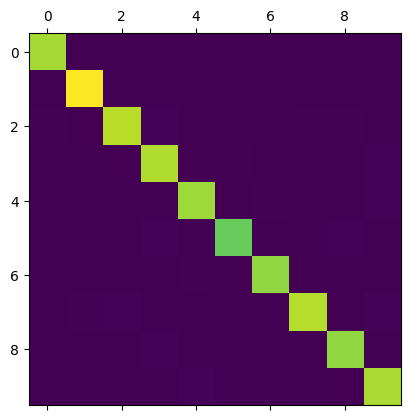

In [52]:
prediction = clf.predict(x_test)
acc = confusion_matrix(y_test, prediction)
print(f"Accuracy: {acc}")
plt.matshow(acc)

1_1.png
Label: 1 | prediction: [1]


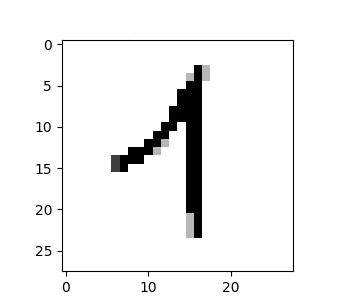

1_2.png
Label: 1 | prediction: [8]


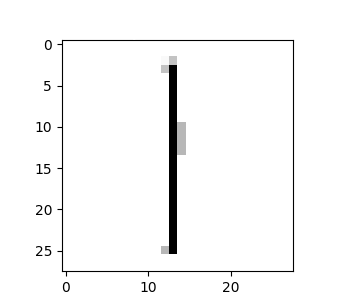

Digit_one.png
Label: 1 | prediction: [3]


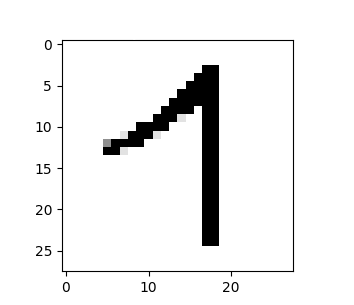

2_1.png
Label: 2 | prediction: [2]


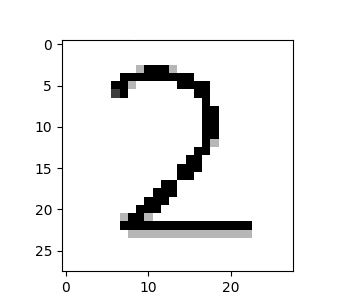

Digit_two.png
Label: 2 | prediction: [2]


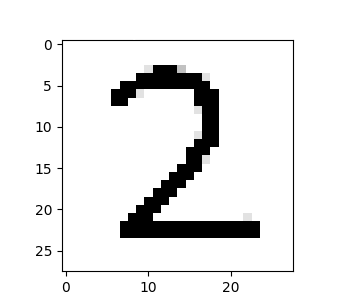

3_1.png
Label: 3 | prediction: [3]


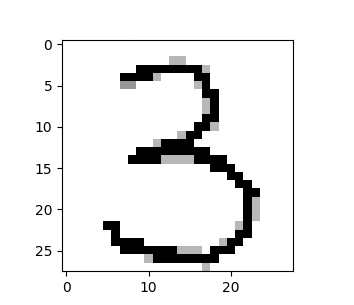

Digit_four.png
Label: 4 | prediction: [4]


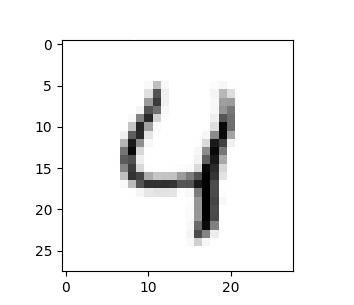

Digit_five (2).png
Label: 5 | prediction: [3]


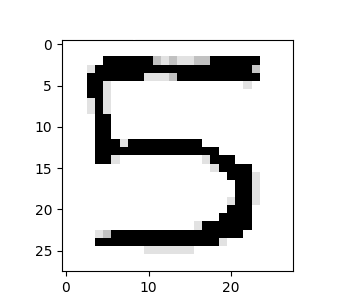

Digit_five.png
Label: 5 | prediction: [5]


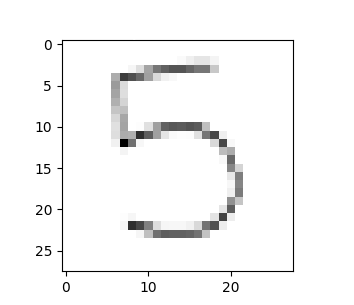

In [56]:
def read_image(file_path):
	""" Read one image from a path """
	img = Image.open(file_path)
	img = img.convert("L")
	img = img.resize((28,28))
	data = list(img.getdata())
	for i in range(len(data)):
		data[i] = 255 - data[i]
	data = [data]
	data = np.array(data)/256
	return data

folders = os.listdir('Media/Test')
number = 9; counter = 1
# fig = plt.figure(figsize=(20,20))
for i in folders:
	images = os.listdir(f"Media/Test/{i}")
	for j in images:
		# Prediction
		image_data = read_image(f"Media/Test/{i}/{j}")
		# predictions_vector = model.predict(image_data)
		# predictions = [ np.argmax(i) for i in predictions_vector ]
		predictions = clf.predict(image_data)
		print(j)
		print(f"Label: {i} | prediction: {predictions}")
		# Graph
		# fig.add_subplot(1, number, counter, xticks=[], yticks=[])
		plt.figure(figsize=(3,3))
		plot = image_data.reshape(28,28)
		plt.imshow(plot, cmap='Greys')
		plt.title(f'Label: {i} | prediction: {predictions}', color='white', size=20)
		plt.show()
		counter += 1

## Tensorflow NN

In [57]:
# Building the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(28*28,)))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(10, activation='softmax')) # Output layer

# Compiling the model
model.compile(
	loss = 'categorical_crossentropy', 
	optimizer='adam', 
	metrics=['accuracy'])
model.summary()

C:\Users\Evgeni Zorin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
model.fit( x_train_smaller, y_train_smaller_2, epochs=15, batch_size=10 )

Epoch 1/15
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8484 - loss: 0.4898
Epoch 2/15
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9454 - loss: 0.1778
Epoch 3/15
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9605 - loss: 0.1362
Epoch 4/15
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9653 - loss: 0.1132
Epoch 5/15
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9691 - loss: 0.1015
Epoch 6/15
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9704 - loss: 0.0951
Epoch 7/15
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9716 - loss: 0.0911
Epoch 8/15
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9750 - loss: 0.0842
Epoch 9/15
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9764 - loss: 0.0750
Epoch 10/15
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9769 - loss: 0.0749
Epoch 11/15
5520/5520 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9779 - loss: 0.0691
Epoch 12/15
5520/55

In [61]:
# Check overall accuracy on the test set
score = model.evaluate( x_val, y_val_2 )
print(f"Test loss: {score[0]:.2f}")
print(f"Test accuracy: {score[1]:.2f}")

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9784 - loss: 0.0854
Test loss: 0.10
Test accuracy: 0.98


In [62]:
cross_val_score( clf, x_val, y_val_2, cv=3, scoring="f1_weighted" )

array([0.91332925, 0.9291448 , 0.92495948])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


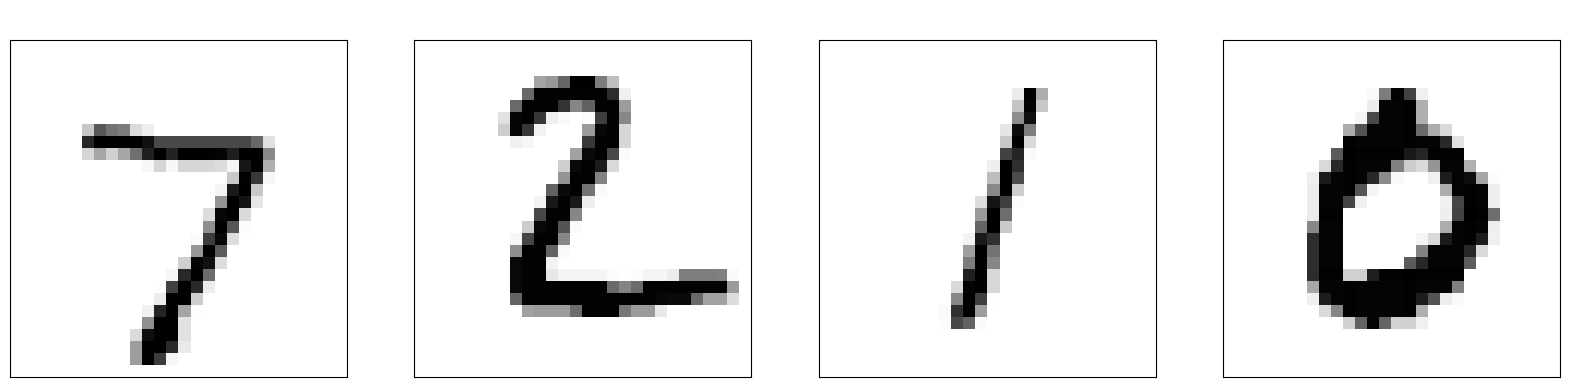

In [63]:
# Let us also check some individual predictions and their accuracy
predictions_vector = model.predict(x_test)
predictions = [ np.argmax(i) for i in predictions_vector ]

fig = plt.figure(figsize=(20,20))
number = 4
for i in range(number):
	fig.add_subplot(1, number, i+1, xticks=[], yticks=[])
	plot = x_test[i].reshape(28,28)
	plt.imshow(plot, cmap='Greys')
	plt.title(f'Label: {np.argmax(y_test2[i])} | prediction: {predictions[i]}', color='white', size=20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1_1.png
Label: 1 | prediction: [1]


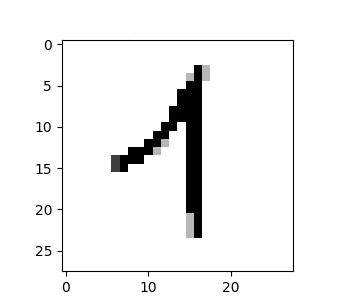

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1_2.png
Label: 1 | prediction: [3]


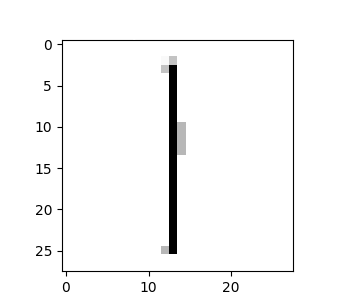

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Digit_one.png
Label: 1 | prediction: [7]


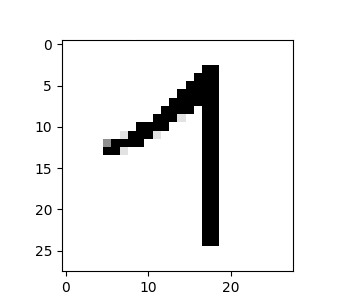

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2_1.png
Label: 2 | prediction: [2]


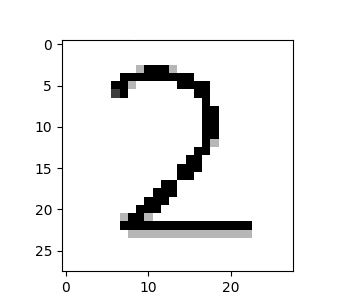

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Digit_two.png
Label: 2 | prediction: [2]


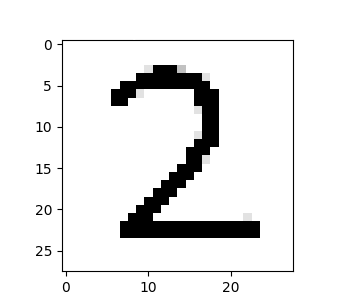

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
3_1.png
Label: 3 | prediction: [3]


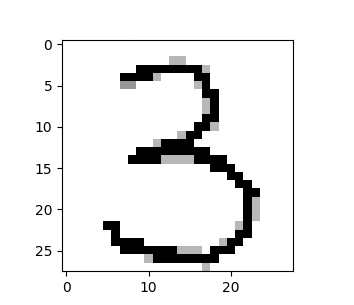

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Digit_four.png
Label: 4 | prediction: [4]


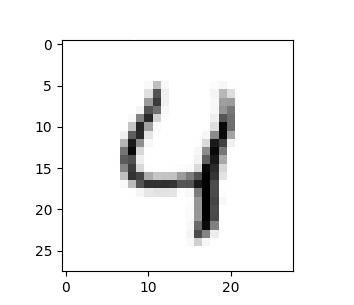

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Digit_five (2).png
Label: 5 | prediction: [5]


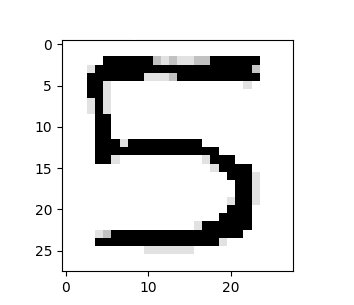

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Digit_five.png
Label: 5 | prediction: [5]


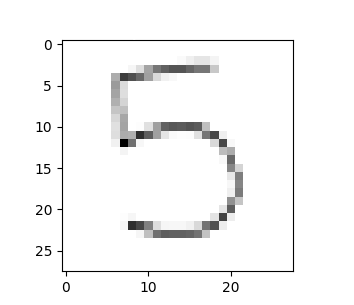

In [64]:
# # We can also load some custom images to test

def read_image(file_path):
	""" Read one image from a path """
	img = Image.open(file_path)
	img = img.convert("L")
	img = img.resize((28,28))
	data = list(img.getdata())
	for i in range(len(data)):
		data[i] = 255 - data[i]
	data = [data]
	data = np.array(data)/256
	return data

folders = os.listdir('Media/Test')
number = 9; counter = 1
# fig = plt.figure(figsize=(20,20))
for i in folders:
	images = os.listdir(f"Media/Test/{i}")
	for j in images:
		# Prediction
		image_data = read_image(f"Media/Test/{i}/{j}")
		predictions_vector = model.predict(image_data)
		predictions = [ np.argmax(i) for i in predictions_vector ]
		predictions
		print(j)
		print(f"Label: {i} | prediction: {predictions}")
		# Graph
		# fig.add_subplot(1, number, counter, xticks=[], yticks=[])
		plt.figure(figsize=(3,3))
		plot = image_data.reshape(28,28)
		plt.imshow(plot, cmap='Greys')
		plt.title(f'Label: {i} | prediction: {predictions}', color='white', size=20)
		plt.show()
		counter += 1

In [ ]:
"""
As we can see, the predictions are very accurate. 

The times when it is not accurate are with 1s (ones), which is likely due to 
the MNIST dataset containing ones written as a stick without the smaller stick.

For this, later I could implement a DL model based on my own writings. 
""";

'\nAs we can see, the predictions are very accurate. \n\nThe times when it is not accurate are with 1s (ones), which is likely due to \nthe MNIST dataset containing ones written as a stick without the smaller stick.\n\nFor this, later I could implement a DL model based on my own writings. \n'